In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
seed = 42
np.random.seed(seed)
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats
import scipy
import cvxopt
import autograd
import autograd.numpy as np
import domain_adapt.domain_adapt.new.fxns as fxns
import domain_adapt.domain_adapt.new.utils as utils
import domain_adapt.domain_adapt.new.optimizers as optimizers
import domain_adapt.domain_adapt.SDR_data as data

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


Couldn't import dot_parser, loading of dot files will not be possible.


In [11]:
# test weighted_lsqr_loss gradient

np.random.seed(42)

random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 15, 20
xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)

u_dim = 1
B = utils.ortho(np.array([[1.,2.]]).T)
ws = np.random.uniform(size=num_train)

tradeoff = 10.

weighted_lsqr_loss_fxn = fxns.two_step( # B, xs_train, xs_test, ys_train, sigma, b_logreg, c_lsqr
    g=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios), # b_logreg, xs_train, xs_test, sigma, B
    h=fxns.sum( # B, xs_train, ys_train, ws_train, c_lsqr
        fs=[
            fxns.fxn.autograd_fxn(_val=fxns.weighted_lsqr_loss), # B, xs_train, ys_train, ws_train, c_lsqr
            fxns.fxn.autograd_fxn(_val=fxns.weight_reg), # ws_train
            ],
        fs_argnums=[
            (0,1,2,3,4),
            (3,),
        ],
        weights=[
            1.,
            tradeoff,
        ]
        ),
    g_argnums=(5,1,2,4,0),
    h_argnums=(0,1,3,6),
    g_val_h_argnum=3,
)
b_logreg = np.random.normal(size=num_train+num_test)
sigma = np.array([.5])
c_lsqr = 0.1
weighted_lsqr_loss_fxn.grad_check(B, xs_train, xs_test, ys_train, sigma, b_logreg, c_lsqr, care_argnums=(0,))

anal_grad (2, 1)
[[ 1777.48927002]
 [ -735.72454156]]
numerical_grad (2, 1)
[[ 1785.46975838]
 [ -734.64481467]]
error 8.05319840986


In [12]:
# test logreg ratio gradient, naive

# get data
random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 15, 20
xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)

# 
#w_max = 10
#eps = 0.001
logreg_ratio_objective = fxns.logreg_ratio_objective.autograd_fxn()
dlogreg_ratio_objective_db = fxns.dopt_objective_dx.autograd_fxn(logreg_ratio_objective)
damp = .1
def lstsq_solver(A,b): 
    ans = scipy.sparse.linalg.lsmr(A, b, damp=damp)
    print ans, 'end'
    return ans[0]
#lstsq_solver = lambda A,b: scipy.sparse.linalg.lsmr(A, b, damp=damp)[0]
cg_solver = lambda A,b: scipy.sparse.linalg.cg(A, b)[0]
lsmr_solver = None
lin_solver = cg_solver
b_opt_given_B_fxn = fxns.cvx_opt( # xs_train, xs_test, sigma, B, c_logreg
    lin_solver=lin_solver, 
    objective=logreg_ratio_objective, 
    dobjective_dx=dlogreg_ratio_objective_db
)
sigma = np.array([2.5])
print sigma
B = utils.ortho(np.array([[1.,2.]]).T)
c_logreg = 0.1
b_opt = b_opt_given_B_fxn.val(xs_train, xs_test, sigma, B, c_logreg)
b_opt_given_B_fxn.grad_check(xs_train, xs_test, sigma, B, c_logreg, care_argnums=(3,))

[ 2.5]
num_tight: 0
solver error: 2.38801990533e-06
num_tight: 0
solver error: 2.36509372658e-06
anal_grad (35, 2, 1)
[[[ 0.28463626]
  [ 0.55110774]]

 [[-0.64113391]
  [ 0.58984787]]

 [[ 0.68482455]
  [ 0.27423964]]

 [[-0.28224472]
  [-0.03826861]]

 [[-0.22166878]
  [ 0.15400321]]

 [[ 0.70147705]
  [ 0.70634371]]

 [[-0.1973249 ]
  [-0.18801147]]

 [[ 0.64392821]
  [ 0.48137816]]

 [[ 0.73128715]
  [ 0.8438508 ]]

 [[-0.2581464 ]
  [-0.09424683]]

 [[-0.22041924]
  [ 0.07266125]]

 [[ 0.08590343]
  [ 0.60970811]]

 [[ 0.67234491]
  [ 0.85473745]]

 [[ 0.39787863]
  [ 0.2048577 ]]

 [[ 0.13825325]
  [-0.10254857]]

 [[ 0.41217711]
  [-0.78100307]]

 [[-0.39588607]
  [ 0.32940157]]

 [[-0.68237539]
  [ 0.01062067]]

 [[-0.034437  ]
  [-0.1104716 ]]

 [[-0.36368364]
  [-0.20026306]]

 [[-0.4735352 ]
  [-0.10974126]]

 [[ 0.30994421]
  [-0.38739455]]

 [[-0.06649477]
  [ 0.27671272]]

 [[ 0.06251261]
  [-0.34762205]]

 [[-0.31037937]
  [-0.56515861]]

 [[ 0.28621128]
  [-0.03177669]]

In [13]:
# test g_thru_xopt gradient

# get data
random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 15, 20
xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)

#
weighted_lsqr_loss_thru_ws_opt_fxn = fxns.g_thru_f_opt( # ys_train, xs_train, xs_test, sigma, B, c_logreg, c_lsqr
    g=b_opt_given_B_fxn, # xs_train, xs_test, sigma, B, c_logreg
    h=weighted_lsqr_loss_fxn, # B, xs_train, xs_test, ys_train, sigma, b_logreg, c_lsqr
    g_argnums=(1,2,3,4,5), 
    h_argnums=(4,1,2,0,3,6), 
    g_val_h_argnum=5
)
ys_train = np.random.normal(size=15)
sigma = np.array([2.5])
print sigma
B = utils.ortho(np.array([[1.,2.]]).T)
c_lsqr = 0.1
c_logreg = 0.1
weighted_lsqr_loss_thru_ws_opt_fxn.grad_check(ys_train, xs_train, xs_test, sigma, B, c_logreg, c_lsqr, care_argnums=(4,))

[ 2.5]
num_tight: 0
solver error: 2.88130161717e-05
anal_grad (2, 1)
[[-93.24142013]
 [ 52.58759435]]
numerical_grad (2, 1)
[[-93.100583  ]
 [ 52.02161051]]
error 0.583243348125


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


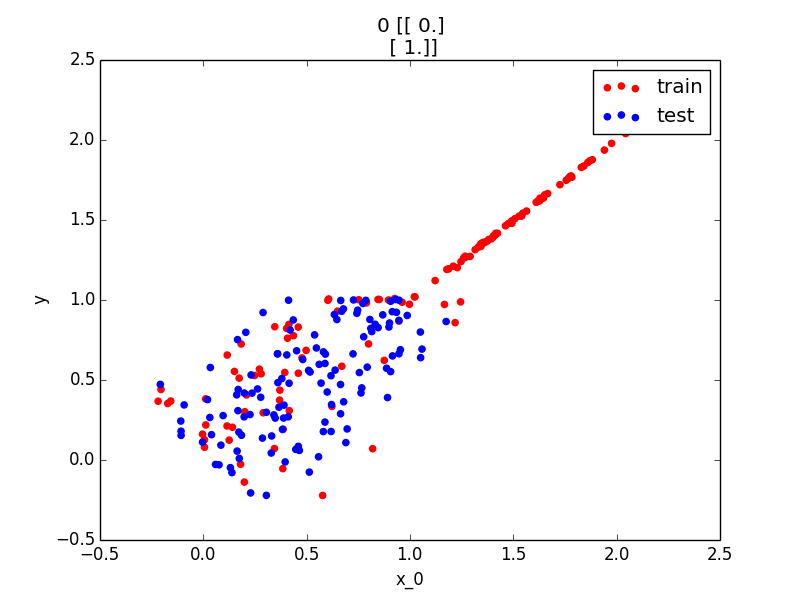

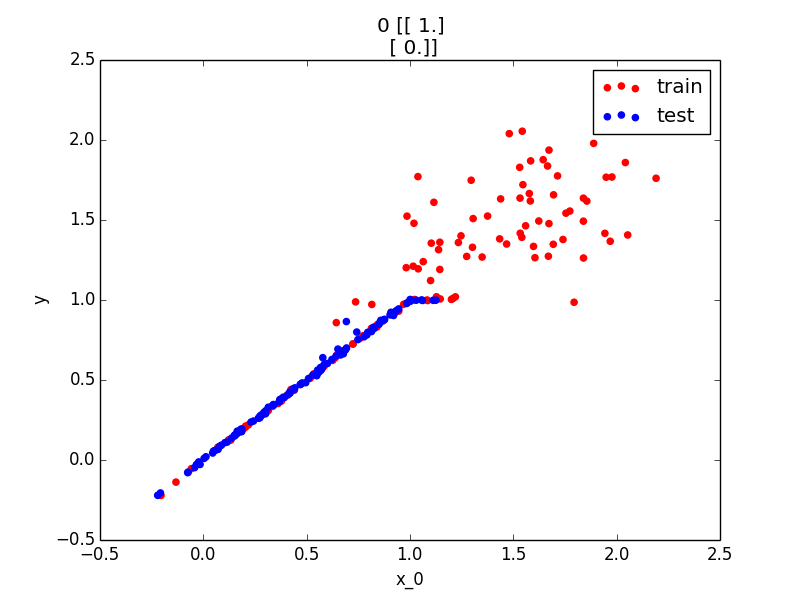

sigma [ 0.25]


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/tight_layout.py:225: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


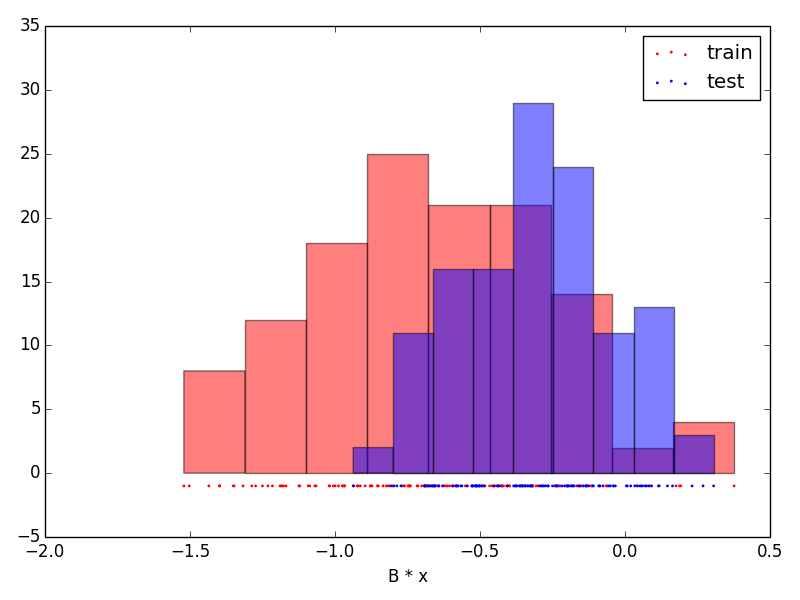

num_tight: 0
solver error: 0.000235633106468
anal_grad (2, 1)
[[-7.98177629]
 [ 3.47690788]]
numerical_grad (2, 1)
[[-7.96665433]
 [ 3.47518855]]
error 0.0152193819945
9.63703246181 objective
num_tight: 0
solver error: 4.19887550111e-05
num_tight: 0
solver error: 1.48903910412e-05
num_tight: 0
solver error: 2.461835994e-05
num_tight: 0
solver error: 6.28224152329e-06
num_tight: 0
solver error: 6.18483496737e-06
num_tight: 0
solver error: 5.35584890844e-06
num_tight: 0
solver error: 5.65573409536e-06
num_tight: 0
solver error: 5.52667505239e-06
num_tight: 0
solver error: 5.61074532507e-06
num_tight: 0
solver error: 5.56245426284e-06
num_tight: 0
solver error: 5.57857333632e-06
num_tight: 0
solver error: 5.57868717926e-06
num_tight: 0
solver error: 5.9098325873e-05
num_tight: 0
solver error: 1.3593890176e-05
num_tight: 0
solver error: 5.93615847685e-06
num_tight: 0
solver error: 8.04481410861e-06
num_tight: 0
solver error: 5.33018380567e-06
num_tight: 0
solver error: 5.71602639334e-06
nu

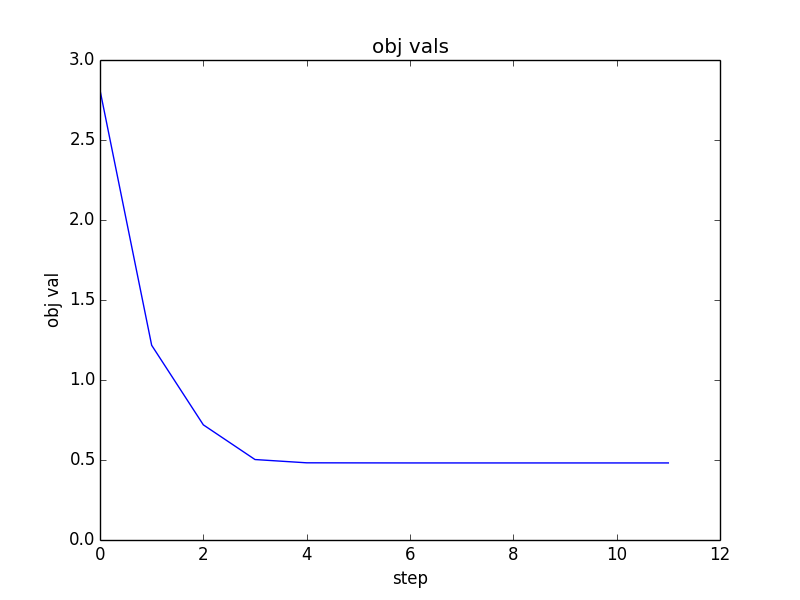

iteration 1
[[-0.98596785]
 [-0.16693531]]


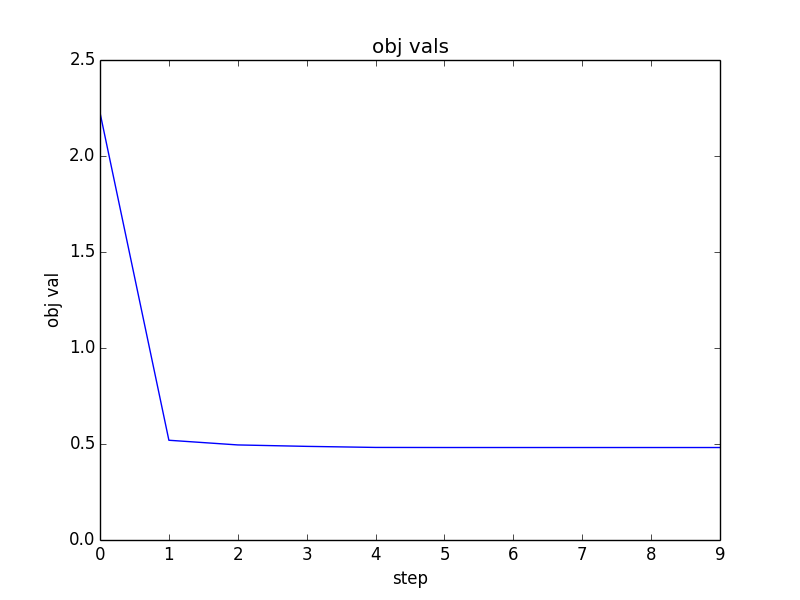

iteration 2
[[ 0.98592034]
 [ 0.16721569]]


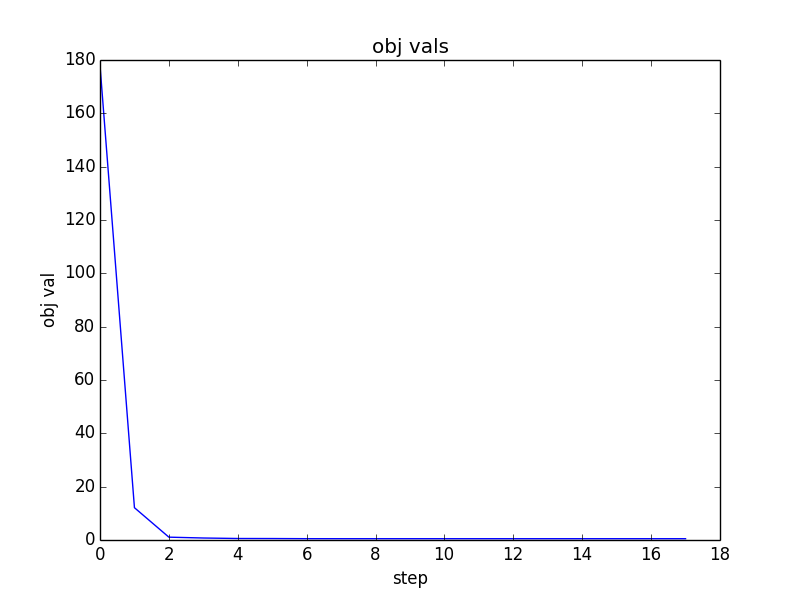

iteration 3
[[ 0.9859536 ]
 [ 0.16701948]]


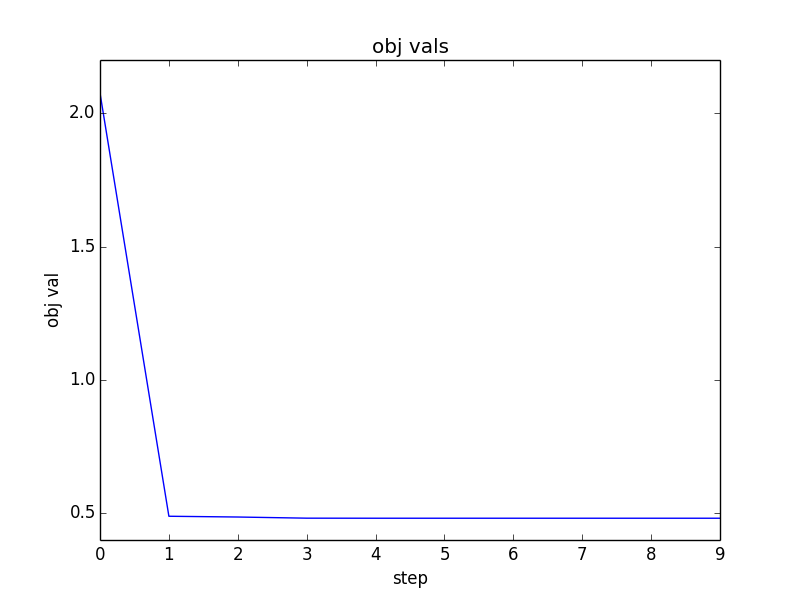

iteration 4
[[ 0.98593267]
 [ 0.16714296]]


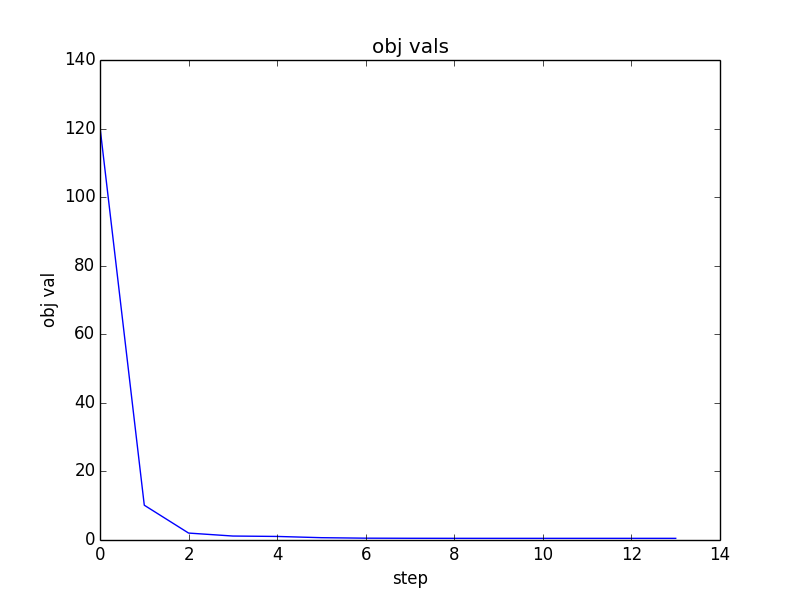

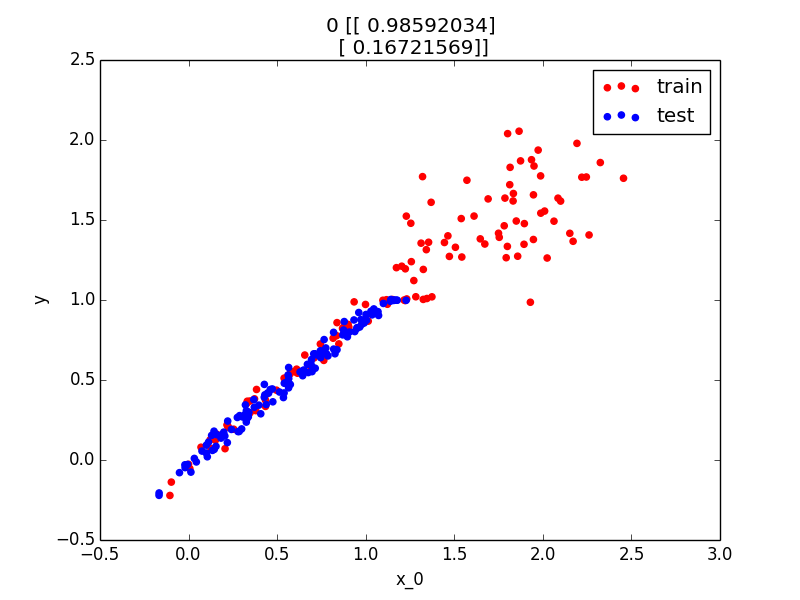

In [7]:
# see if can recover 'true' subspace

np.random.seed(45)

# get data
num_train, num_test = 125, 125
xs_train, xs_test, ys_train, ys_test = data.why_weighting_is_important_data(x_dim=2, num_train=num_train, num_test=num_test)

# plot data
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=np.array([[0.,1.]]).T)
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=np.array([[1.,0.]]).T)

# choose hyperparameter sigma
#sigma = np.array([utils.median_distance(np.vstack((xs_train, xs_test)), np.vstack((xs_train, xs_test)))])
sigma = np.array([.25])
print 'sigma', sigma

# choose B_init
#B_init = utils.ortho(np.random.normal(size=(2,1)))
B_init_f = lambda: utils.ortho(np.random.normal(size=(2,1)))
#B_init_f = lambda: np.array([[1.,0.]]).T
B_init = B_init_f()
c_lsqr = 0.1
c_logreg = 0.1

# plot initial projected data
data.data.plot_us(B_init, xs_train, xs_test)

# define optimizer
objective = lambda B: weighted_lsqr_loss_thru_ws_opt_fxn.val(ys_train, xs_train, xs_test, sigma, B, c_lsqr, c_logreg) # fix.  last 2 arguments are reversed
dobjective_dB = lambda B: weighted_lsqr_loss_thru_ws_opt_fxn.grad(ys_train, xs_train, xs_test, sigma, B, c_lsqr, c_logreg, care_argnums=(4,))

weighted_lsqr_loss_thru_ws_opt_fxn.grad_check(ys_train, xs_train, xs_test, sigma, B, c_lsqr, c_logreg, care_argnums=(4,))

#assert False
print objective(B_init), 'objective'
#assert False

optimizer = optimizers.multiple_optimizer(optimizers.pymanopt_optimizer(), num_tries=5, num_args=1)
u_dim = 1
B_fit = optimizer.optimize(objective, dobjective_dB, B_init_f)
opt_log = optimizer.opt_log
optimizer.plot_objective(opt_log)
#real_B_fit = utils.ortho(B_fit.reshape(B_fit.shape+(1,)))
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=B_fit)

us_train = np.dot(xs_train, B_fit)
us_test = np.dot(xs_test, B_fit)

b_opt = fxns.weighted_lsqr_b_opt(B_fit, xs_train, ys_train, np.ones(num_train), c_lsqr)
ys_test_hat = np.dot(us_test, b_opt)
error = ys_test - ys_test_hat
#print np.dot(error, error), 'error'
print np.linalg.norm(error), 'error'

num_tight: 0
solver error: 0.00302677875769
0
outside grad [-35.55761508]
num_tight: 0
solver error: 3.45130562667e-05
0
outside grad [-2.47824651]
num_tight: 0
solver error: 5.0389687488e-05
0
outside grad [-1.32012008]
num_tight: 0
solver error: 5.96383070785e-05
0
outside grad [-0.67816333]
num_tight: 0
solver error: 6.47308621983e-05
0
outside grad [-0.34475398]
num_tight: 0
solver error: 6.73712252619e-05
0
outside grad [-0.17322242]
[((array([[ 0.96218015],
       [ 0.27241395]]), array([ 0.83481543])), 0.88662678227464464)]
iteration 0


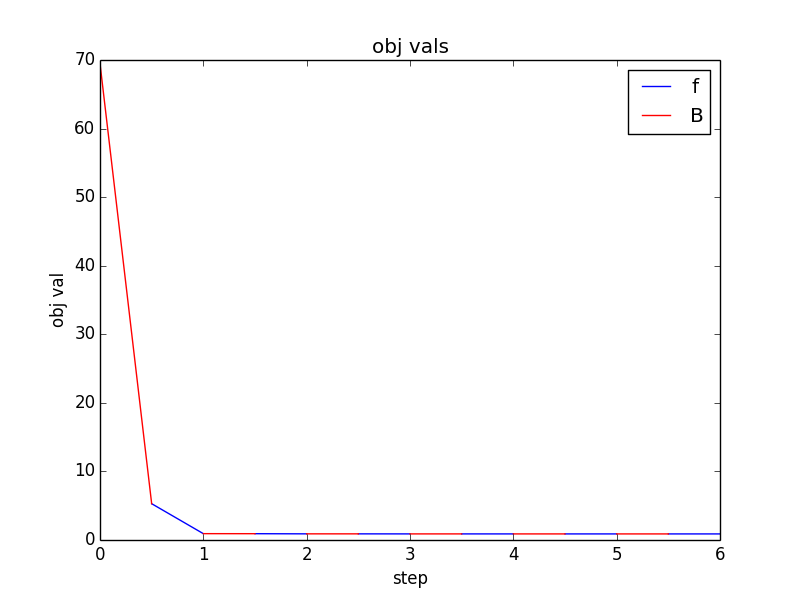

B_fit
[[ 0.96218015]
 [ 0.27241395]]


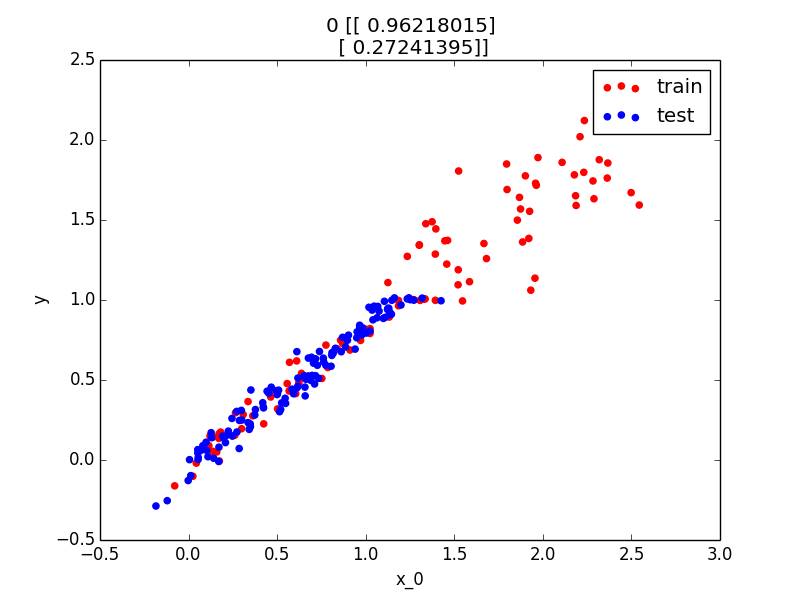

In [12]:
# try to fit true subspace with model that optimizes both B and f, instead of f being optimized out
np.random.seed(42)
# get data
x_dim = 2
random_data = data.random_data(x_dim=x_dim, shift=1.)
num_train, num_test = 100, 125
#xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)
xs_train, xs_test, ys_train, ys_test = data.why_weighting_is_important_data(x_dim=2, num_train=num_train, num_test=num_test)

sigma = np.array([.5])
c_lsqr = 0.1
c_logreg = 0.1
B_init_f = lambda: utils.ortho(np.random.normal(size=(2,1)))
B_init = B_init_f()
#f_init = np.random.normal(size=u_dim)
f_init_f = lambda: np.random.normal(size=u_dim)
f_init = f_init_f()

b_logreg = np.random.normal(size=num_test+num_train)
tradeoff = 10.
weighted_lsqr_loss_given_f_fxn = fxns.two_step( # B, xs_train, xs_test, ys_train, sigma, b_logreg, f, c_lsqr
    g=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios), # b_logreg, xs_train, xs_test, sigma, B
    h=fxns.sum( # B, xs_train, ys_train, f, ws_train, c_lsqr
        fs=[
            fxns.fxn.autograd_fxn(_val=fxns.weighted_lsqr_loss_given_f), # B, xs_train, ys_train, f, ws_train, c_lsqr
            fxns.fxn.autograd_fxn(_val=fxns.weight_reg), # ws_train
            ]
        fs_argnums=[
            (0,1,2,3,4,5),\
            (4,)
        ],
        weights=[
            1.,
            tradeoff,
        ]
        )
    g_argnums=(5,1,2,4,0),
    h_argnums=(0,1,3,6,7),
    g_val_h_argnum=4,
)

#weighted_lsqr_loss_given_f_fxn.grad_check(B_init, xs_train, xs_test, ys_train, sigma, b_logreg, f_init, c_lsqr)

weighted_lsqr_loss_given_f_thru_ws_opt_fxn = fxns.g_thru_f_opt( # ys_train, xs_train, xs_test, sigma, B, f, c_logreg, c_lsqr
    g=b_opt_given_B_fxn, # xs_train, xs_test, sigma, B, c_logreg
    h=weighted_lsqr_loss_given_f_fxn, # B, xs_train, xs_test, ys_train, sigma, b_logreg, f, c_lsqr
    g_argnums=(1,2,3,4,6),
    h_argnums=(4,1,2,0,3,5,7),
    g_val_h_argnum=5,
)
u_dim = 1
#f = np.random.uniform(size=u_dim)
#weighted_lsqr_loss_given_f_thru_ws_opt_fxn.grad_check(ys_train, xs_train, xs_test, sigma, B_init, f_init, c_logreg, c_lsqr, care_argnums=(4,))
#assert False

# define optimizer
objective = lambda B,f: weighted_lsqr_loss_given_f_thru_ws_opt_fxn.val(ys_train, xs_train, xs_test, sigma, B, f, c_logreg, c_lsqr)
dobjective_dB = lambda B,f: weighted_lsqr_loss_given_f_thru_ws_opt_fxn.grad(ys_train, xs_train, xs_test, sigma, B, f, c_logreg, c_lsqr, care_argnums=(4,))
dobjective_df = lambda B,f: weighted_lsqr_loss_given_f_thru_ws_opt_fxn.grad(ys_train, xs_train, xs_test, sigma, B, f, c_logreg, c_lsqr, care_argnums=(5,))
stiefel_optimizer = optimizers.pymanopt_optimizer(maxiter=1)
unconstrained_optimizer = optimizers.linesearch_optimizer(maxiter=1)
optimizer = optimizers.multiple_optimizer(optimizers.B_f_optimizer(stiefel_optimizer, unconstrained_optimizer, maxiter=6), num_tries=1, num_args=2)
#B_init = utils.ortho(np.random.normal(size=(2,1)))

B_fit, f_fit = optimizer.optimize(objective, dobjective_dB, dobjective_df, B_init_f, f_init_f)
opt_log = optimizer.opt_log
optimizer.plot_objective(opt_log)
print 'B_fit'
print B_fit
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=B_fit)


In [16]:
# get data
np.random.seed(45)

# get data
num_train, num_test = 125, 125
xs_train, xs_test, ys_train, ys_test = data.why_weighting_is_important_data(x_dim=2, num_train=num_train, num_test=num_test)

sigma = np.array([.25])
print 'sigma', sigma

B_init_f = lambda: utils.ortho(np.random.normal(size=(2,1)))
#B_init_f = lambda: np.array([[1.,0.]]).T
B_init = B_init_f()

ws_full_train = np.random.uniform(size=num_train)

c_lsqr_loss, c_lsqr_loss_eval, c_lsqr, c_logreg = 0.1, 0., 0.1, 0.1


b_logreg = np.random.normal(size=num_test+num_train)
u_dim=1
b_lsqr = np.random.normal(size=u_dim)
ws_train = np.random.uniform(size=num_train)
ws_full_train = np.random.uniform(size=num_train)

# create b_logreg to objective function
weighted_lsqr_loss_loss_fxn = fxns.two_step(# B, xs_train, ys_train, ws_train, b_lsqr, c_lsqr_loss, c_lsqr_loss_eval
    g=fxns.fxn.autograd_fxn(_val=fxns.b_opt_to_squared_losses), # B, xs_train, ys_train, b_lsqr
    h=fxns.two_step( # B, xs_train, ls_train, ws_train, c_lsqr_loss, c_lsqr_loss_eval
        g=fxns.fxn.autograd_fxn(_val=fxns.weighted_lsqr_b_opt), # B, xs_train, ls_train, ws_train, c_lsqr_loss
        h=fxns.fxn.autograd_fxn(_val=fxns.weighted_squared_loss_given_b_opt), # B, xs_train, ls_train, ws_train, b_lsqr_loss, c_lsqr_loss_eval
        g_argnums=(0,1,2,3,4),
        h_argnums=(0,1,2,3,5),
        g_val_h_argnum=4,
    ),
    g_argnums=(0,1,2,4),
    h_argnums=(0,1,3,5,6),
    g_val_h_argnum=2
)

#weighted_lsqr_loss_loss_fxn.grad_check(B, xs_train, ys_train, ws_train, b_lsqr, c_lsqr_loss, c_lsqr_loss_eval, care_argnums=(0,))
#assert False

upper_bound_fxn = fxns.product( # B, xs_train, ys_train, ws_train, b_lsqr, ws_full_train, c_lsqr_loss, c_lsqr_loss_eval
    g=fxns.fxn.autograd_fxn(_val=fxns.expected_conditional_PE_dist), # ws_full_train, ws_train
    h=weighted_lsqr_loss_loss_fxn, # B, xs_train, ys_train, ws_train, b_lsqr, c_lsqr_loss, c_lsqr_loss_eval
    g_argnums=(5,3),
    h_argnums=(0,1,2,3,4,6,7)
)

#fxns.fxn.autograd_fxn(_val=fxns.expected_conditional_PE_dist).grad_check(ws_full_train, ws_train,care_argnums=(0,))
#assert False
#upper_bound_fxn.grad_check(B, xs_train, ys_train, ws_train, b_lsqr, ws_full_train, c_lsqr_loss, c_lsqr_loss_eval, care_argnums=(0,))
#assert False

tradeoff = 10.

objective_given_ws_and_b_opt = fxns.sum(# B, xs_train, ys_train, ws_train, b_lsqr, ws_full_train, c_lsqr_loss, c_lsqr_loss_eval, c_lsqr
    fs=[
        fxns.fxn.autograd_fxn(_val=fxns.weighted_squared_loss_given_b_opt), # B, xs_train, ys_train, ws_train, b_lsqr, c_lsqr
        upper_bound_fxn, # B, xs_train, ys_train, ws_train, b_lsqr, ws_full_train, c_lsqr_loss, c_lsqr_loss_eval
        fxns.fxn.autograd_fxn(_val=fxns.weight_reg), # ws_train
       ],
    fs_argnums=[
        (0,1,2,3,4,8),
        (0,1,2,3,4,5,6,7),
        (3,)
    ],
    weights=[
        1.,
        1.,
        tradeoff,
    ],
)
    
objective_given_ws = fxns.two_step(# B, xs_train, ys_train, ws_train, ws_full_train, c_lsqr_loss, c_lsqr_loss_eval, c_lsqr
    g=fxns.fxn.autograd_fxn(_val=fxns.weighted_lsqr_b_opt), # B, xs_train, ys_train, ws_train, c_lsqr
    h=objective_given_ws_and_b_opt, # B, xs_train, ys_train, ws_train, b_lsqr, ws_full_train, c_lsqr_loss, c_lsqr_loss_eval, c_lsqr
    g_argnums=(0,1,2,3,7),
    h_argnums=(0,1,2,3,4,5,6,7),
    g_val_h_argnum=4,
)
    
objective_given_b_logreg = fxns.two_step(# b_logreg, xs_train, xs_test, ys_train, ws_full_train, sigma, B, c_lsqr_loss, c_lsqr_loss_eval, c_lsqr
    g=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios),# b_logreg, xs_train, xs_test, sigma, B
    h=objective_given_ws,# B, xs_train, ys_train, ws_train, ws_full_train, c_lsqr_loss, c_lsqr_loss_eval, c_lsqr
    g_argnums=(0,1,2,5,6),
    h_argnums=(6,1,3,4,7,8,9),
    g_val_h_argnum=3,
)
    
# create final objective fxn
final_fxn = fxns.g_thru_f_opt(# ys_train, xs_train, xs_test, ws_full_train, sigma, B, c_lsqr_loss, c_lsqr_loss_eval, c_lsqr, c_logreg
    g=b_opt_given_B_fxn,# xs_train, xs_test, sigma, B, c_logreg
    h=objective_given_b_logreg, # b_logreg, xs_train, xs_test, ys_train, ws_full_train, sigma, B, c_lsqr_loss, c_lsqr_loss_eval, c_lsqr
    g_argnums=(1,2,4,5,9),
    h_argnums=(1,2,0,3,4,5,6,7,8),
    g_val_h_argnum=0
)
    


final_fxn.grad_check(ys_train, xs_train, xs_test, ws_full_train, sigma, B, c_lsqr_loss, c_lsqr_loss_eval, c_lsqr, c_logreg, care_argnums=(5,))

sigma [ 0.25]
num_tight: 0
solver error: 0.000711683729211
anal_grad (2, 1)
[[-4300.93767531]
 [-7249.06834871]]
numerical_grad (2, 1)
[[-4276.81850151]
 [-7186.45988176]]
error 67.0936262174
